In [111]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.style.use('seaborn')
import numpy as np

def plot_pop(N, G, seed=1, ancestral=None, alternate_color=True):
    np.random.seed(seed)
    fig, _ = plt.subplots(figsize=(5, 5))
    plt.scatter(*np.mgrid[:2 * N, :G])
    if ancestral is None:
        ancestral = np.array([False] * 2 * N)
        ancestral[0] = ancestral[-1] = True
    for i in range(G):
        parents = np.sort(np.random.choice(2 * N, replace=True, size=2 * N))
        new_ancestral = np.array([False] * 2 * N)
        for j, (p, a) in enumerate(zip(parents, ancestral)):
            x = [j, p]
            y = [G-i, G-(i + 1)]
            if alternate_color:
                plt.plot(x, y, color='red' if a else "grey")
            elif a:
                plt.plot(x, y, color='red')
            new_ancestral[p] |= ancestral[j]
        ancestral = new_ancestral
    plt.ylabel("Generations before present")
    plt.xlabel("Gene")
    plt.ylim(G, 0)
    
import msprime as msp
from IPython.display import SVG

def draw_tree(**kwargs):
    return SVG(next(msp.simulate(**kwargs).trees()).draw(format='svg'))

# Lecture 3: Wright-Fisher and Coalescent Theory

In the last two lectures we saw examples of the Wright-Fisher model. The basic assumptions of this model were:

- Haploid reproduction (no sex)
- Discrete generations
- Random mating
- Fixed population size $2N$
- Neutrality (no natural selection / fitness advantage)

We will now prove a few famous results concerning this model. These will serve as a segue to coalescent theory.

## Allele fixation
If we assign a "type" to each member of the population, say $A$ or $a$, then argued showed by simulation that the probability that $A$ drifts to fixation is $i/2N$, where $i$ is the number of $A$ alleles in the population at generation 0. We now prove this.

**Proposition 1**. Let $X_t$ be the number of $A$ alleles in the population at generation $t$, so that $X_0$ is the initial number of $A$ alleles. Let $\tau = \min\{t: X_t\in \{0,2N\}\}$. Then $\mathbb{P}(X_\tau = 2N) = \frac{X_0}{2N}$.

*Proof*. By the assumptions of the Wright-Fisher model, we have $$X_{t+1}\mid X_t \sim \mathrm{Binomial}(2N, X_t/(2N)).$$ This implies that the Markov chain $X_0,X_1,\dots$ is a martingale. As $X_t$ is bounded, the [optional stopping theorem](https://en.wikipedia.org/wiki/Optional_stopping_theorem) implies that $\mathbb{E}X_\tau = \mathbb{E}X_0 = X_0$. Thus, $X_0 = \mathbb{E}X_{\tau} = 2N \mathbb{P}(X_\tau = 2N),$ as claimed.

**Corollary**. Suppose that each in generation, new mutations occur with probability $\mu$ in each individual. If a mutation happens, then it has frequency $X_0=1/(2N)$, so its probability of fixation is that as well. The rate of new mutations in the whole population is $2N\mu$, so the rate of new mutations which fix and are not lost to drift is $2N\mu/(2N)=\mu$. 

## Speed of fixation
The preceding results tell us the rate of fixation occurs, but does not say anything about how fast that happens (i.e. how big or small is $\tau$). Our next result establishes the speed of fixation. To do this we define the so-called *heterozygosity*

$$H^0_t = \frac{2X_t (2N- X_t)}{2N(2N-1)}$$

to be the probability (conditional on $X_t$) that a pair of genes chosen randomly without replacement in generation $t$ are different. Note that $H^0_t = 0 \iff \tau < t$, to this indeed tells us about the speed of fixation.

**Proposition 2**. We have $$\mathbb{E}H^0_t = \Big(1-\frac{1}{2N}\Big)^t H_0^0,$$ where $H_0^0$ is the initial heterozygosity of the population.

*Proof*. We will consider two genes and trace their ancestry back in time. To make this more concrete, I used the code from Lecture 2 to generate an example Wright-Fisher model with $N=5$ and ran it for ten generations:

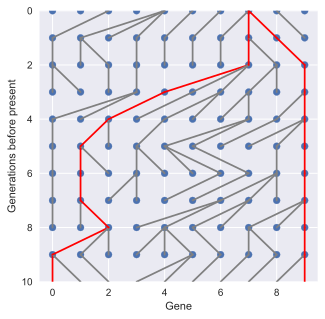

In [49]:
plot_pop(5, 10, seed=1)

We'll look at the genes labeled `0` and `9`, colored in <span style="color:red">red</span>. The probability that they have *different* parents in generation 1 is clearly $1 - (2N)^{-1}$. So, the probability that they have different ancestors all the way back to generation $t$ is $$\Big(1-\frac{1}{2N}\Big)^t.$$ The complement of this event is the probability that the have a common ancestor at some point before $t$. (In our model, `0` and `9` have different ancestors before generation `10`, and the same ancestor from `10` on back into the past.)

Now, in order for `0` and `9` to be different, it must be the case that they had different parents all the way back to the founding generation, and that their founding parent(s) were different. Note that this does not happen in the above plot, but it does happen here, where I run the simulation with a different random seed:

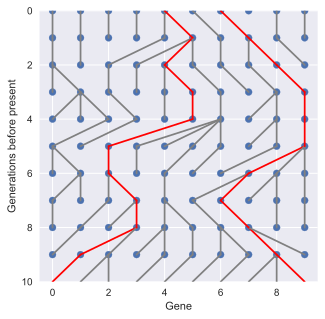

In [50]:
plot_pop(5, 10, seed=2)

Hence, the probability that two genes are different is the product of these two independent events:

$$\mathbb{E}H_t^0 = \Big(1-\frac{1}{2N}\Big)^t H_0^0.$$

Notes:
  - Apart from intrinsic interest, I have included this result because its proof illustrates the sort of backwards-in-time thinking that we will use a lot when proving results about the coalescent in the next part of the lecture.
  - We did not have time to cover this result during Lecture 2, but there is code to simulate it in the notebook.

## Why we care about drift and fixation
Several of the preceding results are due to [Motoo Kimura](https://en.wikipedia.org/wiki/Motoo_Kimura). Kimura was a proponent of the [neutral theory of evolution](https://en.wikipedia.org/wiki/Neutral_theory_of_molecular_evolution), which holds that most evolution is due to the fixation of neutral alleles via random drift. So, results like the previous one can be used to quantify the extent to which that occurs.

The neutral theory was controversial when Kimura introduced it in the late 1960s. It paints a very different view of evolution from the Darwinian one taught in grade school. This led in the 1970s and 1980s to heated debates between the ["neutralists" and "selectionists"](https://en.wikipedia.org/wiki/History_of_molecular_evolution#The_neutralist-selectionist_debate_and_near-neutrality). Starting around the 1990s, we began to have enough data to test these competing hypothesis, leading to the publication of many different "tests of selection". We'll discuss these further when we study natural selection in a few weeks.

# The coalescent
Next, we will introduce a model serves as the basis for essentially everything else we discuss in this class. The coalescent is a probability distribution over random trees. It describes the distribution of trees that are embedded in the W-F process, examples of which we saw in the last lecture:

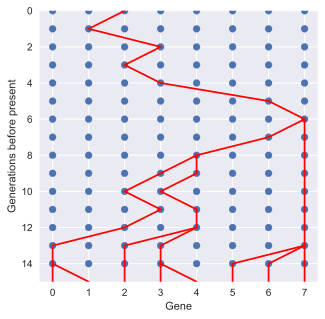

In [73]:
plot_pop(4, 15, seed=2, ancestral=[True] * 10, alternate_color=False)

This is a random tree that joins the 8 "leaf" nodes sampled at the present. In this example, all the nodes find an overall common ancestor in generation 6.

## Time to coalescence in a pair of samples
In the proof of proposition 2, we noted that the probability that two lineages have not found a common ancestor by generation $t$ is $$\Big(1-\frac{1}{2N}\Big)^t.$$ Denote this event by $C_t^C$ (the complement of the event that they have found a common ancestor, or *coalesced*, by time $t$), and define $\bar{t}=t/(2N)$. (Thus if the "rescaled time" $\bar{t}=1$, then $2N$ generations have elapsed.) Then, equivalently, $$\mathbb{P}(C_t^C) = \big(1-\frac{1}{2N}\Big)^{2N \bar{t}} \to e^{-\bar{t}}.$$
This says that if we measure time in units of $2N$ generations, and $N$ is large, then $\mathbb{P}(C_t^C) \approx e^{-t}$.

## Larger samples
We can extend this reasoning to more than two lineages. Suppose that we look at $k$ lineages in the present generation. We want to calculate the probability that they all have distinct parents in the preceding generation. To do this we'll imagine throwing $k$ balls uniformly at random into $2N$ boxes to assign parentage, as the W-F model does.

The first ball lands in any one of the boxes. The second ball avoids the first ball's box with probability $(2N-1)/(2N)$. And so forth. So the probability that they all have different parents is 
\begin{align}
\frac{(2N-1)(2N-2)\dots(2N-k+1)}{(2N)^{k-1}}
&=\Big(1-\frac{1}{2N}\Big)\cdots \Big(1-\frac{k-1}{2N}\Big)\\
&=1-\frac{\sum_{i=1}^{k-1} i}{2N} + O\Big(\frac{1}{N^2}\Big)\\
&=1-\frac{\binom{k}{2}}{2N} + O\Big(\frac{1}{N^2}\Big).
\end{align}

Thus, after $2Nt$ generations, the probability that there have been no coalescences in this sample is 
$$\Big[1-\frac{\binom{k}{2}}{2N} + O\Big(\frac{1}{N^2}\Big)\Big]^{2Nt} \to e^{-\binom{k}{2}t}.$$

This says that the time to first coalescence in a sample of size $k\ll N$ is exponentially distributed with mean $1/\binom{k}{2}$.

## Partition structure
The preceding results tell us how much time elapses between coalescent events. The other component of the gene tree is its "topological structure". This is easy: conditional on a coalescent event happening, it chooses uniformly at random from among the remaining lineages. Thus we can model the coalescent as a stochastic process on partitions of the sample size $n$. In fact this is how it was originally described.

## A simulation algorithm
The above results give us a way to simulate gene trees. The algorithm is quite simple:

In [90]:
import random

def sim_tree(n):
    'Simulate a gene tree for `n` individuals under the coalescent'
    blocks = [[{i} for i in range(n)]]  # initial partition structure
    times = []
    for k in range(n, 1, -1):
        # draw a random time from an Exponential(\binom{k}{2}) distribution.
        times.append(np.random.exponential(2 / k / (k - 1)))
        # merge two "blocks" uniformly at random.
        b = blocks[-1]
        random.shuffle(b)
        blocks.append(b[2:] + [b[0] | b[1]])
    return times, blocks

sim_tree(5)

([0.05442711782290689,
  0.12949086909978336,
  0.3125406764647971,
  1.7501368071084162],
 [[{1}, {4}, {2}, {0}, {3}],
  [{1, 4}, {3}, {2}, {0}],
  [{1, 3, 4}, {2}, {0}],
  [{0}, {1, 2, 3, 4}],
  [{0, 1, 2, 3, 4}]])

We can visualize these trees by using the coalescent simulation package `msprime`:

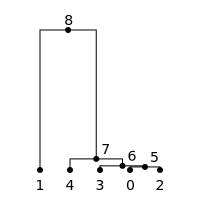

In [100]:
# !pip install msprime
import msprime as msp
from IPython.display import SVG

SVG(next(msp.simulate(sample_size=5).trees()).draw(format='svg'))

## Statistics of the coalescent
From the above algorithm, we can see the total height (distance from leaves to root) of the coalescent tree in a sample of size $n$ is is $T_n + T_{n-1} + \cdots + T_2$, where $T_k \sim \mathrm{Exponential}(\binom{k}{2})$. From this, the expected "time to most recent common ancestor" is $$\mathbb{E}T_\text{MRCA}=\sum_{k=2}^n \mathbb{E}T_k = 2 \sum_{k=2}^n \frac{1}{k(k-1)} = 2\Big(1-\frac{1}{n}\Big)$$ where the final identity follows from the telescoping sum. By a similar computation, the variance can be shown equal to $$\operatorname{Var}(T_\text{MRCA}) = \sum_{k=2}^n \frac{1}{k^2} - (\mathbb{E}T_\text{MRCA})^2.$$

### The human MRCA
This says that the expected time to most recent common ancestor is around 2 units of "coalescent time". To convert this to generations, we need to make an assumption about what a reasonable value of $2N$ is. We will return to this question when we discuss techniques for estimating the size history of a population. A reasonable baseline value for humans is $N\approx 10^4$. So, the result suggests that all humans are descended from someone who lived around $4N=4\times 10^4$ generations ago. If we assume that the human generation time is 25 years, this comes out to $10^6$ years ago. However, this assumes a simple model in which the size of the human population is constant over time. In reality, populations grow and contract, and in particular, the size of the human population was much smaller at various points in the past than it is currently. Estimates which take this into account place the value of the human TMRCA and 100,000-200,000 years ago.

Notes:
- The coalescent was first described by English mathematician [JFC Kingman](https://en.wikipedia.org/wiki/John_Kingman), who proved convergence of the W-F model to it in a pair of landmark papers in 1982. 
- For a more rigorous proof of these statements, as well as many other properties of the coalescent, see Kingman's original papers, or chapter 3 of Wakeley's book.
- The assumption that $N$ is large is crucial here. If $N$ is not large, then you cannot ignore the probability of three or more lineages finding a common ancestor in the same generation. 
- For the same reason, we also need $k\ll N$. Nowadays, we have huge "BioBanks" of data availabel. For example, the [UK BioBank](https://www.ukbiobank.ac.uk) has collected genetic data from about 1% of people in the United Kingdom. At this scale, the coalescent begins to break down. Recent research has focused on what happens to the coalescent when $k$ is of the same order as $N$.

# Mutations
Generating gene trees is useful for theoretical investigations, but we never actually observe them. Instead, we observe patterns of genetic variation that were generated along a gene tree. From now on, we will let $\theta/2$ denote the rate of mutations that occur in one unit of coalescent time along one lineage. 

Here is the basic idea. A random gene tree generated under the coalescent looks like:

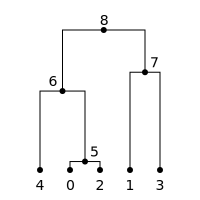

In [119]:
draw_tree(sample_size=5, random_seed=1)

To add mutations to this process, we proceed in one of two equivalent ways:
1. Generate the tree first. Then, given the tree, let $K \sim \operatorname{Poisson}(T\theta/2)$, where $T$ is the sum of all of the branch lengths on the tree. Given $K$, sprinkle $K$ mutations uniformly at random along the branches of the tree.
2. Alter the coalescent algorithm described above: when there are $k$ lineages remaining, generate the time to the next event by drawing an exponential random variable with rate $k\theta/2 + \binom{k}{2}$. With probability $$\frac{k\theta/2}{k\theta/2 + \binom{k}{2}} = \frac{\theta}{\theta + k-1},$$ the next event is a mutation; otherwise it is a coalescence.

In either case, we wind up with a tree that looks like:

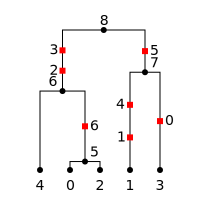

In [120]:
draw_tree(sample_size=5, random_seed=1, mutation_rate=1)

## The infinite alleles model
What do these mutations represent? We will study several models. The firs is the so-called *infinite alleles* model. An *allele* is simple a type of gene. For example, in the previous lectures we studied the classical case of a biallelic gene. We labeled the two types of the gene by $A$ and $a$. In reality, genes consist of DNA. The length of a typical gene in the human genome is around a few thousand nucleotides in length, and a mutation could hit any of them. So there are a huge number of possible alleles for any given gene.

For example, here is the DNA sequence for the gene [TNF](https://en.wikipedia.org/wiki/Tumor_necrosis_factor):

    >NG_007462.1:4993-7764 Homo sapiens tumor necrosis factor (TNF), RefSeqGene on chromosome 6
    AGCAGACGCTCCCTCAGCAAGGACAGCAGAGGACCAGCTAAGAGGGAGAGAAGCAACTACAGACCCCCCC
    TGAAAACAACCCTCAGACGCCACATCCCCTGACAAGCTGCCAGGCAGGTTCTCTTCCTCTCACATACTGA
    CCCACGGCTCCACCCTCTCTCCCCTGGAAAGGACACCATGAGCACTGAAAGCATGATCCGGGACGTGGAG
    CTGGCCGAGGAGGCGCTCCCCAAGAAGACAGGGGGGCCCCAGGGCTCCAGGCGGTGCTTGTTCCTCAGCC
    TCTTCTCCTTCCTGATCGTGGCAGGCGCCACCACGCTCTTCTGCCTGCTGCACTTTGGAGTGATCGGCCC
    CCAGAGGGAAGAGGTGAGTGCCTGGCCAGCCTTCATCCACTCTCCCACCCAAGGGGAAATGGAGACGCAA
    GAGAGGGAGAGAGATGGGATGGGTGAAAGATGTGCGCTGATAGGGAGGGATGGAGAGAAAAAAACGTGGA
    GAAAGACGGGGATGCAGAAAGAGATGTGGCAAGAGATGGGGAAGAGAGAGAGAGAAAGATGGAGAGACAG
    GATGTCTGGCACATGGAAGGTGCTCACTAAGTGTGTATGGAGTGAATGAATGAATGAATGAATGAACAAG
    CAGATATATAAATAAGATATGGAGACAGATGTGGGGTGTGAGAAGAGAGATGGGGGAAGAAACAAGTGAT
    ATGAATAAAGATGGTGAGACAGAAAGAGCGGGAAATATGACAGCTAAGGAGAGAGATGGGGGAGATAAGG
    AGAGAAGAAGATAGGGTGTCTGGCACACAGAAGACACTCAGGGAAAGAGCTGTTGAATGCCTGGAAGGTG
    AATACACAGATGAATGGAGAGAGAAAACCAGACACCTCAGGGCTAAGAGCGCAGGCCAGACAGGCAGCCA
    GCTGTTCCTCCTTTAAGGGTGACTCCCTCGATGTTAACCATTCTCCTTCTCCCCAACAGTTCCCCAGGGA
    CCTCTCTCTAATCAGCCCTCTGGCCCAGGCAGTCAGTAAGTGTCTCCAAACCTCTTTCCTAATTCTGGGT
    TTGGGTTTGGGGGTAGGGTTAGTACCGGTATGGAAGCAGTGGGGGAAATTTAAAGTTTTGGTCTTGGGGG
    AGGATGGATGGAGGTGAAAGTAGGGGGGTATTTTCTAGGAAGTTTAAGGGTCTCAGCTTTTTCTTTTCTC
    TCTCCTCTTCAGGATCATCTTCTCGAACCCCGAGTGACAAGCCTGTAGCCCATGTTGTAGGTAAGAGCTC
    TGAGGATGTGTCTTGGAACTTGGAGGGCTAGGATTTGGGGATTGAAGCCCGGCTGATGGTAGGCAGAACT
    TGGAGACAATGTGAGAAGGACTCGCTGAGCTCAAGGGAAGGGTGGAGGAACAGCACAGGCCTTAGTGGGA
    TACTCAGAACGTCATGGCCAGGTGGGATGTGGGATGACAGACAGAGAGGACAGGAACCGGATGTGGGGTG
    GGCAGAGCTCGAGGGCCAGGATGTGGAGAGTGAACCGACATGGCCACACTGACTCTCCTCTCCCTCTCTC
    CCTCCCTCCAGCAAACCCTCAAGCTGAGGGGCAGCTCCAGTGGCTGAACCGCCGGGCCAATGCCCTCCTG
    GCCAATGGCGTGGAGCTGAGAGATAACCAGCTGGTGGTGCCATCAGAGGGCCTGTACCTCATCTACTCCC
    AGGTCCTCTTCAAGGGCCAAGGCTGCCCCTCCACCCATGTGCTCCTCACCCACACCATCAGCCGCATCGC
    CGTCTCCTACCAGACCAAGGTCAACCTCCTCTCTGCCATCAAGAGCCCCTGCCAGAGGGAGACCCCAGAG
    GGGGCTGAGGCCAAGCCCTGGTATGAGCCCATCTATCTGGGAGGGGTCTTCCAGCTGGAGAAGGGTGACC
    GACTCAGCGCTGAGATCAATCGGCCCGACTATCTCGACTTTGCCGAGTCTGGGCAGGTCTACTTTGGGAT
    CATTGCCCTGTGAGGAGGACGAACATCCAACCTTCCCAAACGCCTCCCCTGCCCCAATCCCTTTATTACC
    CCCTCCTTCAGACACCCTCAACCTCTTCTGGCTCAAAAAGAGAATTGGGGGCTTAGGGTCGGAACCCAAG
    CTTAGAACTTTAAGCAACAAGACCACCACTTCGAAACCTGGGATTCAGGAATGTGTGGCCTGCACAGTGA
    AGTGCTGGCAACCACTAAGAATTCAAACTGGGGCCTCCAGAACTCACTGGGGCCTACAGCTTTGATCCCT
    GACATCTGGAATCTGGAGACCAGGGAGCCTTTGGTTCTGGCCAGAATGCTGCAGGACTTGAGAAGACCTC
    ACCTAGAAATTGACACAAGTGGACCTTAGGCCTTCCTCTCTCCAGATGTTTCCAGACTTCCTTGAGACAC
    GGAGCCCAGCCCTCCCCATGGAGCCAGCTCCCTCTATTTATGTTTGCACTTGTGATTATTTATTATTTAT
    TTATTATTTATTTATTTACAGATGAATGTATTTATTTGGGAGACCGGGGTATCCTGGGGGACCCAATGTA
    GGAGCTGCCTTGGCTCAGACATGTTTTCCGTGAAAACGGAGCTGAACAATAGGCTGTTCCCATGTAGCCC
    CCTGGCCTCTGTGCCTTCTTTTGATTATGTTTTTTAAAATATTTATCTGATTAAGTTGTCTAAACAATGC
    TGATTTGGTGACCAACTGTCACTCATTGCTGAGCCTCTGCTCCCCAGGGGAGTTGTGTCTGTAATCGCCC
    TACTATTCAGTGGCGAGAAATAAAGTTTGCTTAGAAAAGAAA

This gene is about 3,000 nucleotides long. If a mutation hits this gene, it would create a new type or "allele". If another mutation hit it, the chances of it mutating back to the original type would be about $1/3000 \times 1/3$, which is the probability that the mutation lands at the same site as the first, times the probability that it mutates back to the original nucleotide. Otherwise, it would create another new type. Continuing in this fashion, we can reasonably assume that every new mutation creates a new allele.

#### Example of infinite alleles model
Let's see how this works on actual (simulated) data. Looking back at the tree we just generated:

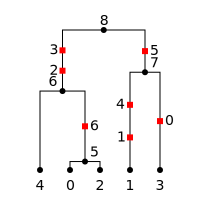

In [121]:
draw_tree(sample_size=5, mutation_rate=1, random_seed=1)

Each of the red dots denotes a mutation that fell on this tree. The rule is, if your ancestor has a mutation, then so do you.

There are:
- Three types that have only one copy in the sample: `3/2` possesed by node 4, `5/4/1` possesed by node 1, and `5/0` possesed by node 3.
- One type that has two copies in the sample: `3/2/6`, possessed by nodes 0 and 2.

We record these entries in an *allelic partition vector* $\mathbf{a}\in \mathbf{Z}^n$. The $k$th entry $a_k$ encodes the number of alleles that have $k$ copies in the sample. So for the above example, $\mathbf{a}=\left<3,1,0,0,0\right>.$

## Ewens' sampling formula (ESF)
The distribution of the random vector $\mathbf{a}$ is given by a famous formula due to [Warren Ewens](https://en.wikipedia.org/wiki/Warren_Ewens). In the statement of the theorem, we use the notation $\theta_{(n)}$ to denote the rising factorial function: $\theta_{(n)}=\theta(\theta+1)\cdots(\theta+n-1)$.

**Theorem** (Ewens' sampling formula). Let $\mathbf{a}\in \mathbb{Z}^n$ be generated by a coalescent tree with $n$ samples under the infinite alleles model with mutation rate $\theta$. Then $$\mathbb{P}(\mathbf{a}) = \frac{n!}{\theta_{(n)}} \prod_{i=1}^n \left(\frac{\theta}{i}\right)^{a_i}\frac{1}{a_i!}\times \mathbf{1}\left\{\sum_{i=1}^n i a_i=n\right\}.$$

### Proof of ESF
Let us think about how a coalescent tree with mutations is generated, using the algorithm we sketched above.

Each allele defines a cluster of leaf nodes which share that allele. In our running example, the clusters are `{0,2},{4},{1},{3}`. Under the infinite alleles model, within each cluster, we only need to trace the ancestry back to the point where the first/most recent mutation occurs. For example, the probability of the cluster `{0,2}` is the probability that `0` and `2` coalesce, and then experience a mutation.

For the general allelic partition vector $\mathbf{a}$ whose probability we wish to compute, the number of clusters is $k=\sum_{i=1}^n a_k$. Let the cluster sizes be $\lambda_1,\dots,\lambda_k$, such that $|\{j:\lambda_j = k\}| = a_k$. Note we could permute any blocks of the clustering that have the same size--a total of $a_1!a_2!\cdots a_n!$ possible permutations--and still get the same sequence $\lambda_1,\dots,\lambda_k$. For now we will just fix one such permutation.

Now, the probability that a cluster containing $i$ lineages experiences a coalescence depends on how many other lineages remain. When there are $j$ lineages remaining, the probability that a coalescence occurs within the cluster is 
$$\frac{\binom{j}{2}}{j\theta/2 + \binom{j}{2}} \frac{\binom{i}{2}}{\binom{j}{2}}=\frac{i(i-1)}{j\theta+j(j-1)}.$$
Similarly, after the cluster has coalesced down to a single remaining lineage, if there are $j$ lineages remaining then the probability that the cluster experiences a mutation is 
$$\frac{\theta/2}{j\theta/2+\binom{j}{2}}=\frac{\theta}{j\theta + j(j-1)}.$$

Given a clustering, there must have been some ordering of the events that eventually led to every cluster having a single ancestor and then getting hit by a mutation. In the running example above, that *particular* sequence of events was:
1. `0` and `2` coalesced.
2. `1` experienced a mutation.
3. `{0,2}` experienced a mutation.
4. `{3}` experienced a mutation.
5. `{4}` experienced a mutation.


If we take the product of these probabilities over all clusters with sizes $\lambda_1,\dots,\lambda_k$, then the probability of the clustering for a particular sequence of events is:

$$\frac{\prod_{i=1}^k \theta \lambda_i! (\lambda_i-1)!}{\prod_{i=1}^n i(\theta + i-1)} 
=\frac{\theta^k \prod_{i=1}^k \lambda_i! (\lambda_i-1)!}{n! \theta_{(n)}}.
$$

Since there are $\binom{n}{\lambda_1,\dots,\lambda_k}$ different sequences of events that could have led to this clustering, we get that the probability of a clustering with given block sizes $\lambda_1,\dots,\lambda_k$ is 

$$\binom{n}{\lambda_1,\dots,\lambda_k} \frac{\theta^k \prod_{i=1}^k \lambda_i! (\lambda_i-1)!}{n! \theta_{(n)}} = \frac{\theta^k \prod_{i=1}^k (\lambda_i-1)!}{\theta_{(n)}}.$$

Finally, to compute the probability $\mathbb{P}(\mathbf{a})$, we need to think about the relationship between $\mathbf{a}$ and the $\lambda_1,\dots,\lambda_k$. There are a total of $\binom{n}{\lambda_1,\dots\,\lambda_k}$ clusterings of $[n]$ with the given block sizes. Above we argued that there are $a_1!\cdots a_n!$ different ways to permute the $\lambda_i$. So, we get
\begin{align}
\mathbb{P}(\mathbf{a}) &= \frac{\theta^k \prod_{i=1}^k (\lambda_i-1)!}{\theta_{(n)}} \times 
\binom{n}{\lambda_1,\dots,\lambda_k} \frac{1}{a_1!\cdots a_n!} \\
&= \frac{n!\theta^k \prod_{i=1}^k (1/\lambda_k)}{\theta_{(n)}} \times 
\frac{1}{a_1!\cdots a_n!} \\
&= \frac{n!}{\theta_{(n)}}\prod_{i=1}^n \left(\frac{\theta}{i}\right)^{a_i} \frac{1}{a_i!},
\end{align}
where in the last equality we used the facts that $\theta^k = \theta^{\sum_i a_i}$ and $\prod_{i=1}^k \lambda_k = \prod_{i=1}^n i^{a_i}$.